### 1. What is the purpose of this experiment?
LGBMをアンサンブルの1つとするにあたり、ベンチマークを作成する。
F1 Scoreと学習に使う時間を確認する。
また、TFIDFとEmbeddingの2通りを試す
### 2. Why do you this?
多様なモデルを作る為
### 3. Where are the points of technology and techniques?
LGBM, TFIDF or Word Embedding
### 4. How do you validate the effectiveness?
処理時間
F1 Score
### 5. What will you do next?
NNとアンサンブルしてLBを確認する。学習時間を確認する

In [1]:
is_local = False
st_time = time.time()

%load_ext autoreload
%autoreload 2
from tqdm import tqdm
import numpy as np
import pandas as pd
import time
from contextlib import contextmanager
import datetime
import sys
import re
import gc
import glob
import pickle as pkl
import os

from joblib import Parallel, delayed
from multiprocessing import Pool
import multiprocessing
def pararell_process(func, arg_list, cpu_cnt=multiprocessing.cpu_count()):
    process = Pool(cpu_cnt)
    callback = process.map_async(func, arg_list).get(600)
    process.close()
    process.terminate()
    return callback

def mkdir_func(path):
    try:
        os.stat(path)
    except:
        os.mkdir(path)

from logging import StreamHandler, DEBUG, Formatter, FileHandler, getLogger
def logger_func():
    logger = getLogger(__name__)
    log_fmt = Formatter('%(asctime)s %(name)s %(lineno)d [%(levelname)s]\
    [%(funcName)s] %(message)s ')
    handler = StreamHandler()
    handler.setLevel('INFO')
    handler.setFormatter(log_fmt)
    logger.addHandler(handler)

    mkdir_func('../output')
    handler = FileHandler('../output/py_train.py.log', 'a')
    handler.setLevel(DEBUG)
    handler.setFormatter(log_fmt)
    logger.setLevel(DEBUG)
    logger.addHandler(handler)

    logger.info('start')

    return logger
logger = logger_func()


@contextmanager
def timer(name):
    """
    Taken from Konstantin Lopuhin https://www.kaggle.com/lopuhin
    in script named : Mercari Golf: 0.3875 CV in 75 LOC, 1900 s
    https://www.kaggle.com/lopuhin/mercari-golf-0-3875-cv-in-75-loc-1900-s
    """
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')
    
# NLP
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import string

key = 'qid'
qt = 'question_text'
target = 'target'

2018-11-25 15:47:20,392 __main__ 50 [INFO]    [logger_func] start 


### Cleansing Method

In [2]:
# Contraction replacement patterns
cont_patterns = [
    (b'(W|w)on\'t', b'will not'),
    (b'(C|c)an\'t', b'can not'),
    (b'(I|i)\'m', b'i am'),
    (b'(A|a)in\'t', b'is not'),
    (b'(\w+)\'ll', b'\g<1> will'),
    (b'(\w+)n\'t', b'\g<1> not'),
    (b'(\w+)\'ve', b'\g<1> have'),
    (b'(\w+)\'s', b'\g<1> is'),
    (b'(\w+)\'re', b'\g<1> are'),
    (b'(\w+)\'d', b'\g<1> would'),
]
patterns = [(re.compile(regex), repl) for (regex, repl) in cont_patterns]

def prepare_for_char_n_gram(text):
    """ Simple text clean up process"""
    # 1. Go to lower case (only good for english)
    # Go to bytes_strings as I had issues removing all \n in r""
    clean = bytes(text.lower(), encoding="utf-8")
    # 2. Drop \n and  \t
    clean = clean.replace(b"\n", b" ")
    clean = clean.replace(b"\t", b" ")
    clean = clean.replace(b"\b", b" ")
    clean = clean.replace(b"\r", b" ")
    # 3. Replace english contractions
    for (pattern, repl) in patterns:
        clean = re.sub(pattern, repl, clean)
    # 4. Drop puntuation
    # I could have used regex package with regex.sub(b"\p{P}", " ")
    exclude = re.compile(b'[%s]' % re.escape(bytes(string.punctuation, encoding='utf-8')))
    clean = b" ".join([exclude.sub(b'', token) for token in clean.split()])
    # 5. Drop numbers - as a scientist I don't think numbers are toxic ;-)
    clean = re.sub(b"\d+", b" ", clean)
    # 6. Remove extra spaces - At the end of previous operations we multiplied space accurences
    clean = re.sub(b'\s+', b' ', clean)
    # Remove ending space if any
    clean = re.sub(b'\s+$', b'', clean)
    # 7. Now replace words by words surrounded by # signs
    # e.g. my name is bond would become #my# #name# #is# #bond#
    # clean = re.sub(b"([a-z]+)", b"#\g<1>#", clean)
#     clean = re.sub(b" ", b"# #", clean)  # Replace space
#     clean = b"#" + clean + b"#"  # add leading and trailing #

    return str(clean, 'utf-8')

def count_regexp_occ(regexp="", text=None):
    """ Simple way to get the number of occurence of a regex"""
    return len(re.findall(regexp, text))

def cleansing_text(text, remove_stopwords=True):

    # Convert words to lower case and split them
    text = re.sub("_", " ", text, flags=re.IGNORECASE)
    text = text.lower().split()
    regex_num = re.compile(u"[0-9０-９]")

    # Optionally, remove stop words
    if remove_stopwords:
        stops = STOPWORDS
        text = [w for w in text if (not w in stops) and not(regex_num.match(w))]

    text = " ".join(text)

    # Clean the text
    text = re.sub(" whats ", " what is ", text, flags=re.IGNORECASE)
    text = re.sub("[c-fC-F]\:\/", " disk ", text)
    text = re.sub("\'d", " would ", text)
    text = re.sub("\'ll", " will ", text)
    text = re.sub("\'re", " are ", text)
    text = re.sub("\'s", " ", text) # we have cases like "Sam is" or "Sam's" (i.e. his) these two cases aren't separable, I choose to compromise are kill "'s" directly
    text = re.sub("\'ve", " have ", text)
    text = re.sub("\(s\)", " ", text, flags=re.IGNORECASE)
    text = re.sub("`", "'", text) # special single quote
    text = re.sub("e-mail", " email ", text, flags=re.IGNORECASE)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub("b\.g\.", " bg ", text, flags=re.IGNORECASE)
    text = re.sub("e\.g\.", " eg ", text, flags=re.IGNORECASE)
    text = re.sub("i'm", "i am", text, flags=re.IGNORECASE)
    text = re.sub("é", "e", text)
    text = re.sub("’", "'", text) # special single quote
    text = re.sub("“", '"', text) # special double quote
    text = re.sub("…", " ", text)
    text = re.sub("？", "?", text)
    text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)
    text = re.sub('\$', " dollar ", text)
    text = re.sub('\%', " percent ", text)
    text = re.sub('\&', " and ", text)
    
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\W|^)([0-9]+)[kK](\W|$)", r"\1\g<2>000\3", text) # better regex provided by @armamut
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"what's", "what is ", text)

    # Original
    text = re.sub(r" u s ", " America ", text)
    text = re.sub("(the[\s]+|The[\s]+)?U\.S\.A\.", " America ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?United State(s)?", " America ", text, flags=re.IGNORECASE)
    text = re.sub(r" (the[\s]+|The[\s]+)?US(A)? ", " America ", text)
    text = re.sub(r" UK ", " England ", text, flags=re.IGNORECASE)
    text = re.sub(r" india ", " India ", text)
    text = re.sub(r" switzerland ", " Switzerland ", text)
    text = re.sub(r" china ", " China ", text)
    text = re.sub(r" chinese ", " Chinese ", text)
    text = re.sub(r" quora ", " Quora ", text, flags=re.IGNORECASE)
    text = re.sub(r" qoura ", " Quora ", text)
    text = re.sub(r" upvote", " up vote", text, flags=re.IGNORECASE)
    text = re.sub(r" iPhone ", " phone ", text, flags=re.IGNORECASE)
    text = re.sub(r" J K ", " JK ", text, flags=re.IGNORECASE)
    text = re.sub(r" J\.K\. ", " JK ", text, flags=re.IGNORECASE)
    text = re.sub(r"(?=[a-zA-Z])ig ", "ing ", text)
    
    return text

### Data Load

In [3]:
def quara_load_data():
    train = pd.read_csv('../input/train.csv')
    test = pd.read_csv('../input/test.csv')
    return train, test

train, test = quara_load_data()
# Load id Text List
train_id_list = list(train[key].values)
test_id_list = list(test[key].values)
train_text_list = list(train[qt].values)
test_text_list = list(test[qt].values)
id_list = train_id_list + test_id_list
text_list = train_text_list + test_text_list

raw_trn_idx = list(train.index)
raw_test_idx = list(test.index)
y = train[target]

del train, test
gc.collect()

print(train_text_list[:10])

['How did Quebec nationalists see their province as a nation in the 1960s?', 'Do you have an adopted dog, how would you encourage people to adopt and not shop?', 'Why does velocity affect time? Does velocity affect space geometry?', 'How did Otto von Guericke used the Magdeburg hemispheres?', 'Can I convert montra helicon D to a mountain bike by just changing the tyres?', 'Is Gaza slowly becoming Auschwitz, Dachau or Treblinka for Palestinians?', 'Why does Quora automatically ban conservative opinions when reported, but does not do the same for liberal views?', 'Is it crazy if I wash or wipe my groceries off? Germs are everywhere.', 'Is there such a thing as dressing moderately, and if so, how is that different than dressing modestly?', 'Is it just me or have you ever been in this phase wherein you became ignorant to the people you once loved, completely disregarding their feelings/lives so you get to have something go your way and feel temporarily at ease. How did things change?']


### Cleansing Start

In [4]:
# Cleansing
with timer("Cleansing Dataset"):
    # 並列処理でクレンジング
    train_text_list = Parallel(n_jobs=-1)( [delayed(cleansing_text)(args) for args in train_text_list] )
    train_text_list = Parallel(n_jobs=-1)( [delayed(prepare_for_char_n_gram)(args) for args in train_text_list] )
    test_text_list = Parallel(n_jobs=-1)( [delayed(cleansing_text)(args) for args in test_text_list] )
    test_text_list = Parallel(n_jobs=-1)( [delayed(prepare_for_char_n_gram)(args) for args in test_text_list] )
    text_list = train_text_list + test_text_list

[Cleansing Dataset] done in 63 s


### TFIDF
ngramはいくつかパターンを試す
実験のため、tfidf matrixとvecotorizerは保存しておく

In [5]:
ngram_range=(1,1)
# ngram_range=(1,2)

def get_tfidf(text_list):
    '''
    Explain:
        テキストを1要素としてもったリストを渡し、TFIDFベクトルをもったsparse matrixを出力する
    Args:
        text_list(list): split前のテキストリスト. 1テキストが1つのTFIDFベクトルに変換される
    Return:
        sparse csr_matrix: TFIDF値が入ったスパースな行列
    '''
    # Get the tfidf
    with timer("Fitting TFIDF"):
        # TFIDFに変換するオブジェクトを作成する
        tfidf_vectorizer = TfidfVectorizer(
            max_features = 10000,
            min_df=10,
            max_df=0.5,
            stop_words="english",
            analyzer='word',
            #  analyzer='char',
            strip_accents='unicode',
            ngram_range=ngram_range,
            use_idf=True,
            smooth_idf=True,
            sublinear_tf=True
        ).fit(text_list)

    # Train, Testのテキストが順番に並んだリストを渡すと、各テキストをTFIDFベクトルに変換して返してくれる
    # テキストに対応するインデックスを渡して返ってくるのが対応するTFIDFベクトル
    with timer("Transform TFIDF"):
        csr_tfidf = tfidf_vectorizer.transform(text_list)
    return csr_tfidf, tfidf_vectorizer

# TFIDF
csr_tfidf, tfidf_vectorizer = get_tfidf(text_list)

# Kernel実行の場合は分岐
if is_local:
    HOME = os.path.expanduser("~")
    sys.path.append(f"{HOME}/kaggle/data_analysis/library/")
    import utils
    utils.to_pkl_gzip(obj=tfidf_vectorizer, path='../input/bench_vectorizer_tfidf30000.gz')
    utils.to_pkl_gzip(obj=csr_tfidf, path='../input/bench_csr_tfidf30000.gz')
    sys.path.append(f'{HOME}/kaggle/data_analysis/model')
    from params_lgbm import params_quara
else:
    del text_list
    gc.collect()

[Fitting TFIDF] done in 11 s
[Transform TFIDF] done in 10 s


### LGBM

In [10]:
train_st_time = time.time()
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import log_loss, confusion_matrix, f1_score, accuracy_score
start_time = "{0:%Y%m%d_%H%M%S}".format(datetime.datetime.now())

# Variables
tfidf_vocablary = tfidf_vectorizer.vocabulary_.items()
feature_list = np.array(tfidf_vectorizer.get_feature_names())
del tfidf_vectorizer
gc.collect()

def f1_calculation(y_val, y_pred):
    for thresh in np.arange(0.1, 0.401, 0.01):
        thresh = np.round(thresh, 2)
        f1 = f1_score(y_val, (y_pred>thresh).astype(int))
        logger.info(f"F1 score at threshold {thresh} is {f1}")
        

def lgbm_train(train_test, feature_list):

    # LGBM Args
    model_type = 'lgb'
    fold_type = 'stratified'
    metric = 'accuracy'
    fold = 5
    learning_rate = 0.1
    early_stopping_rounds = 100
    num_boost_round = 10000
    seed = 1208
    params = {
        'num_threads': -1,
        'metric': 'binary_logloss',
        'objective': 'binary',
        'boosting_type':'gbdt',
        'bagging_freq': 1,
        'sigmoid': 1.1,
        'subsample': 0.9,
        'colsample_bytree': 0.2,
        'lambda_l1': 1,
        'lambda_l2': 5,
        'learning_rate': 0.1,
        'num_leaves': 100,
        'max_depth': 9,
        'bagging_seed': 1208,
        'data_random_seed': 1208,
        'feature_fraction_seed': 1208,
        'random_seed': 1208,
        'verbose': 1
    }

    # Result
    select_features = [] # Feature Importanceによって選択したfeature群を入れるリスト
    prediction = np.zeros(len(trn_idx))

    with timer("LGBM Setting"):

        # testも結合されてるので、trainのみにする
#         tmp_train = csr_tfidf[raw_trn_idx]
        tmp_train = train_test[raw_trn_idx]

        ' KFold '
        if fold_type == 'stratified':
            folds = StratifiedKFold(n_splits=fold, shuffle=True, random_state=seed)
            kfold = folds.split(tmp_train, y)

    cv_feim = pd.DataFrame() # Feature Importanceの結果ファイルを入れるDF
    for n_fold, (trn_idx, val_idx) in enumerate(kfold):

        with timer(f"Validation: {n_fold} | LGBM Train"):
            x_train, y_train = tmp_train[trn_idx], y[trn_idx]
            x_val, y_val = tmp_train[val_idx], y[val_idx]

            # Dataset
            lgb_train = lgb.Dataset(data=x_train, label=y_train)
            lgb_eval = lgb.Dataset(data=x_val, label=y_val)

            estimator = lgb.train(
                train_set=lgb_train,
                valid_sets=lgb_eval,
                params=params,
                verbose_eval=200,
                early_stopping_rounds=early_stopping_rounds,
                num_boost_round=num_boost_round
            )

        with timer(f"Validation: {n_fold} | Prediction & Get F1 score"):
            y_pred = estimator.predict(x_val)
            score = log_loss(y_val, y_pred)
            logger.info(f'Fold No: {n_fold} | {metric}: {score}')
            logger.info(f"Train Shape: {x_train.shape}")
            
            prediction[val_idx] = y_pred
            
            f1_calculation(y_val, y_pred)

            ' Feature Importance '
            if len(cv_feim):
                cv_feim[f'{n_fold}_importance'] = estimator.feature_importance(importance_type='gain')
            else:
                feim_name = f'{n_fold}_importance'
                feim = pd.Series(estimator.feature_importance(importance_type='gain'), name=feim_name, index=feature_list).to_frame().reset_index().rename(columns={'index':'feature'})
                cv_feim = feim.copy()
                
        if len(feature_list)>8000:
            break

    if n_fold==4:
        f1_calculation(y, prediction)

    with timer("Save Feature Importance"):
        col_feim = [col for col in cv_feim.columns if col.count('importance')]
        cv_feim['avg_importance'] = cv_feim[col_feim].mean(axis=1)
        cv_feim.sort_values(by='avg_importance', ascending=False, inplace=True)

        from matplotlib import pyplot as plt
        import japanize_matplotlib
        %matplotlib inline
        import seaborn as sns
        plt.figure(figsize=(8, 12))
        display(cv_feim.head())
        sns.barplot(data=cv_feim.iloc[:50, ], x='avg_importance', y='feature')
        plt.show()
        if is_local:
            cv_feim.to_csv(f'../valid/{start_time[4:12]}_{model_type}_TFIDF_f1{f1}_logloss{score}_lr{learning_rate}.csv', index=False)
        tmp_features = list(cv_feim[cv_feim['avg_importance']>30]['feature'].values)
        print(f'Selece Feature: {len(tmp_features)}')
        select_features += tmp_features

    select_features = list(set(select_features))
    print(len(select_features))
    print(sorted(select_features))
    print(f'All done in {time.time() - train_st_time:.0f} s')
    
    return select_features, prediction

[LGBM Setting] done in 0 s
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.149783
[400]	valid_0's binary_logloss: 0.142174
[600]	valid_0's binary_logloss: 0.13824
[800]	valid_0's binary_logloss: 0.135716
[1000]	valid_0's binary_logloss: 0.133919
[1200]	valid_0's binary_logloss: 0.132683
[1400]	valid_0's binary_logloss: 0.13171
[1600]	valid_0's binary_logloss: 0.130919
[1800]	valid_0's binary_logloss: 0.130336
[2000]	valid_0's binary_logloss: 0.129831
[2200]	valid_0's binary_logloss: 0.12945
[2400]	valid_0's binary_logloss: 0.129118
[2600]	valid_0's binary_logloss: 0.128843
[2800]	valid_0's binary_logloss: 0.128607
[3000]	valid_0's binary_logloss: 0.12841
[3200]	valid_0's binary_logloss: 0.128262
[3400]	valid_0's binary_logloss: 0.128119
[3600]	valid_0's binary_logloss: 0.128018
[3800]	valid_0's binary_logloss: 0.127899
[4000]	valid_0's binary_logloss: 0.12786
[4200]	valid_0's binary_logloss: 0.127824
[4400]	valid_0's binary_logloss: 0.12

2018-11-25 16:01:25,760 __main__ 92 [INFO]    [lgbm_train] Fold No: 0 | accuracy: 0.1277639256294626 
2018-11-25 16:01:25,761 __main__ 93 [INFO]    [lgbm_train] Train Shape: (653061, 10000) 
2018-11-25 16:01:25,865 __main__ 17 [INFO]    [f1_calculation] F1 score at threshold 0.1 is 0.5450940193920246 
2018-11-25 16:01:25,969 __main__ 17 [INFO]    [f1_calculation] F1 score at threshold 0.11 is 0.5544137480965847 
2018-11-25 16:01:26,070 __main__ 17 [INFO]    [f1_calculation] F1 score at threshold 0.12 is 0.5619745731537723 
2018-11-25 16:01:26,172 __main__ 17 [INFO]    [f1_calculation] F1 score at threshold 0.13 is 0.5677995827717983 
2018-11-25 16:01:26,271 __main__ 17 [INFO]    [f1_calculation] F1 score at threshold 0.14 is 0.5725736917406504 
2018-11-25 16:01:26,370 __main__ 17 [INFO]    [f1_calculation] F1 score at threshold 0.15 is 0.5770721801735278 
2018-11-25 16:01:26,470 __main__ 17 [INFO]    [f1_calculation] F1 score at threshold 0.16 is 0.5798057249558015 
2018-11-25 16:01:26

[Validation: 0 | Prediction & Get F1 score] done in 28 s
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.149197
[400]	valid_0's binary_logloss: 0.141657
[600]	valid_0's binary_logloss: 0.137881
[800]	valid_0's binary_logloss: 0.135454
[1000]	valid_0's binary_logloss: 0.133681
[1200]	valid_0's binary_logloss: 0.132425
[1400]	valid_0's binary_logloss: 0.131454
[1600]	valid_0's binary_logloss: 0.130697
[1800]	valid_0's binary_logloss: 0.130054
[2000]	valid_0's binary_logloss: 0.129557
[2200]	valid_0's binary_logloss: 0.129154
[2400]	valid_0's binary_logloss: 0.128823
[2600]	valid_0's binary_logloss: 0.12857
[2800]	valid_0's binary_logloss: 0.128328
[3000]	valid_0's binary_logloss: 0.128128
[3200]	valid_0's binary_logloss: 0.127971
[3400]	valid_0's binary_logloss: 0.127868
[3600]	valid_0's binary_logloss: 0.127773
[3800]	valid_0's binary_logloss: 0.127694
[4000]	valid_0's binary_logloss: 0.127647
[4200]	valid_0's binary_logloss: 0.127623
[44

2018-11-25 16:04:20,144 __main__ 92 [INFO]    [lgbm_train] Fold No: 1 | accuracy: 0.12754651043204399 
2018-11-25 16:04:20,145 __main__ 93 [INFO]    [lgbm_train] Train Shape: (653061, 10000) 
2018-11-25 16:04:20,244 __main__ 17 [INFO]    [f1_calculation] F1 score at threshold 0.1 is 0.543802430946657 
2018-11-25 16:04:20,348 __main__ 17 [INFO]    [f1_calculation] F1 score at threshold 0.11 is 0.5533769063180828 
2018-11-25 16:04:20,447 __main__ 17 [INFO]    [f1_calculation] F1 score at threshold 0.12 is 0.5612167847254683 
2018-11-25 16:04:20,542 __main__ 17 [INFO]    [f1_calculation] F1 score at threshold 0.13 is 0.5677554113754413 
2018-11-25 16:04:20,642 __main__ 17 [INFO]    [f1_calculation] F1 score at threshold 0.14 is 0.5728836706435766 
2018-11-25 16:04:20,738 __main__ 17 [INFO]    [f1_calculation] F1 score at threshold 0.15 is 0.5772981583650634 
2018-11-25 16:04:20,834 __main__ 17 [INFO]    [f1_calculation] F1 score at threshold 0.16 is 0.5804972912904569 
2018-11-25 16:04:20

[Validation: 1 | Prediction & Get F1 score] done in 27 s


2018-11-25 16:04:23,324 __main__ 17 [INFO]    [f1_calculation] F1 score at threshold 0.11 is 0.40308643718408493 
2018-11-25 16:04:23,423 __main__ 17 [INFO]    [f1_calculation] F1 score at threshold 0.12 is 0.40694883782375435 
2018-11-25 16:04:23,519 __main__ 17 [INFO]    [f1_calculation] F1 score at threshold 0.13 is 0.4100831640378309 
2018-11-25 16:04:23,616 __main__ 17 [INFO]    [f1_calculation] F1 score at threshold 0.14 is 0.4135051018398141 
2018-11-25 16:04:23,714 __main__ 17 [INFO]    [f1_calculation] F1 score at threshold 0.15 is 0.4157647173711365 
2018-11-25 16:04:23,811 __main__ 17 [INFO]    [f1_calculation] F1 score at threshold 0.16 is 0.4174709168031582 
2018-11-25 16:04:23,912 __main__ 17 [INFO]    [f1_calculation] F1 score at threshold 0.17 is 0.418320320268389 
2018-11-25 16:04:24,010 __main__ 17 [INFO]    [f1_calculation] F1 score at threshold 0.18 is 0.4187917074472818 
2018-11-25 16:04:24,109 __main__ 17 [INFO]    [f1_calculation] F1 score at threshold 0.19 is 0.

,feature,0_importance,1_importance,avg_importance
6558,people,30819.320544,27683.771392,29251.545968
9301,trump,20721.227894,33735.351395,27228.289644
9886,women,29958.725800,22940.338598,26449.532199
5911,muslims,26082.225921,25087.350905,25584.788413
343,americans,18207.443655,17125.304546,17666.374100


/home/ubuntu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


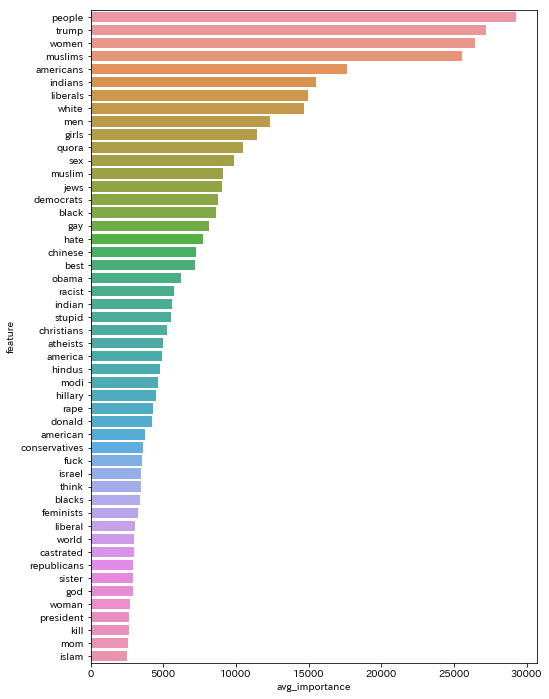

Selece Feature: 2046
[Save Feature Importance] done in 0 s
2046
['aap', 'ability', 'able', 'abortion', 'abortions', 'abuse', 'abusing', 'accept', 'acceptable', 'according', 'account', 'achieve', 'acknowledge', 'act', 'acting', 'actions', 'active', 'activists', 'actually', 'adam', 'add', 'address', 'administration', 'admission', 'admit', 'adolf', 'ads', 'adult', 'advantages', 'advice', 'affairs', 'affect', 'affected', 'afghan', 'afraid', 'africa', 'african', 'africans', 'age', 'agenda', 'agents', 'aggressive', 'ago', 'agree', 'aids', 'air', 'aircraft', 'aka', 'al', 'albanians', 'alex', 'alien', 'aliens', 'alive', 'allah', 'allow', 'allowed', 'allowing', 'alt', 'amazon', 'amendment', 'america', 'american', 'americans', 'analysis', 'ancestors', 'ancient', 'android', 'angry', 'animal', 'animals', 'anime', 'annex', 'annoy', 'annoying', 'answer', 'answering', 'answers', 'anti', 'antifa', 'anus', 'anxiety', 'anybody', 'anymore', 'apartheid', 'apologize', 'app', 'apparently', 'application', 'a

In [11]:
select_features, _ = lgbm_train(csr_tfidf, feature_list)

### Feature Importance 上位のFeature Set

In [12]:
id_list = []
[id_list.append(id)  for word, id in tfidf_vocablary if word in select_features]
print(len(id_list))
print(len(select_features))
# sparse matrixのcolumn No=id No
select_mx = csr_tfidf.T[id_list].T
print(select_mx.shape)

2046
2046
(1362492, 2046)


[LGBM Setting] done in 0 s
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.14994
[400]	valid_0's binary_logloss: 0.142335
[600]	valid_0's binary_logloss: 0.13837
[800]	valid_0's binary_logloss: 0.135826
[1000]	valid_0's binary_logloss: 0.134067
[1200]	valid_0's binary_logloss: 0.132729
[1400]	valid_0's binary_logloss: 0.131762
[1600]	valid_0's binary_logloss: 0.130957
[1800]	valid_0's binary_logloss: 0.130351
[2000]	valid_0's binary_logloss: 0.12987
[2200]	valid_0's binary_logloss: 0.129464
[2400]	valid_0's binary_logloss: 0.129187
[2600]	valid_0's binary_logloss: 0.128969
[2800]	valid_0's binary_logloss: 0.128775
[3000]	valid_0's binary_logloss: 0.128639
[3200]	valid_0's binary_logloss: 0.128574
[3400]	valid_0's binary_logloss: 0.128528
[3600]	valid_0's binary_logloss: 0.128475
Early stopping, best iteration is:
[3630]	valid_0's binary_logloss: 0.128468
[Validation: 0 | LGBM Train] done in 84 s


2018-11-25 16:06:07,165 __main__ 92 [INFO]    [lgbm_train] Fold No: 0 | accuracy: 0.1284683782644453 
2018-11-25 16:06:07,166 __main__ 93 [INFO]    [lgbm_train] Train Shape: (653061, 2046) 
2018-11-25 16:06:07,259 __main__ 17 [INFO]    [f1_calculation] F1 score at threshold 0.1 is 0.5448992677082982 
2018-11-25 16:06:07,350 __main__ 17 [INFO]    [f1_calculation] F1 score at threshold 0.11 is 0.5543720454724186 
2018-11-25 16:06:07,440 __main__ 17 [INFO]    [f1_calculation] F1 score at threshold 0.12 is 0.5616049460601855 
2018-11-25 16:06:07,530 __main__ 17 [INFO]    [f1_calculation] F1 score at threshold 0.13 is 0.5683083432304038 
2018-11-25 16:06:07,619 __main__ 17 [INFO]    [f1_calculation] F1 score at threshold 0.14 is 0.5734339090050828 
2018-11-25 16:06:07,711 __main__ 17 [INFO]    [f1_calculation] F1 score at threshold 0.15 is 0.5776200809336696 
2018-11-25 16:06:07,801 __main__ 17 [INFO]    [f1_calculation] F1 score at threshold 0.16 is 0.5815907953976988 
2018-11-25 16:06:07,

[Validation: 0 | Prediction & Get F1 score] done in 19 s
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.149642
[400]	valid_0's binary_logloss: 0.141997
[600]	valid_0's binary_logloss: 0.138077
[800]	valid_0's binary_logloss: 0.135578
[1000]	valid_0's binary_logloss: 0.133816
[1200]	valid_0's binary_logloss: 0.132489
[1400]	valid_0's binary_logloss: 0.131479
[1600]	valid_0's binary_logloss: 0.13065
[1800]	valid_0's binary_logloss: 0.130059
[2000]	valid_0's binary_logloss: 0.129569
[2200]	valid_0's binary_logloss: 0.129164
[2400]	valid_0's binary_logloss: 0.128844
[2600]	valid_0's binary_logloss: 0.128568
[2800]	valid_0's binary_logloss: 0.128397
[3000]	valid_0's binary_logloss: 0.128264
[3200]	valid_0's binary_logloss: 0.128158
[3400]	valid_0's binary_logloss: 0.128112
[3600]	valid_0's binary_logloss: 0.128058
Early stopping, best iteration is:
[3607]	valid_0's binary_logloss: 0.128053
[Validation: 1 | LGBM Train] done in 84 s


2018-11-25 16:07:51,011 __main__ 92 [INFO]    [lgbm_train] Fold No: 1 | accuracy: 0.12805271750628308 
2018-11-25 16:07:51,012 __main__ 93 [INFO]    [lgbm_train] Train Shape: (653061, 2046) 
2018-11-25 16:07:51,110 __main__ 17 [INFO]    [f1_calculation] F1 score at threshold 0.1 is 0.5451752053418425 
2018-11-25 16:07:51,208 __main__ 17 [INFO]    [f1_calculation] F1 score at threshold 0.11 is 0.5542566864557196 
2018-11-25 16:07:51,305 __main__ 17 [INFO]    [f1_calculation] F1 score at threshold 0.12 is 0.5616295013350653 
2018-11-25 16:07:51,402 __main__ 17 [INFO]    [f1_calculation] F1 score at threshold 0.13 is 0.5683622736717127 
2018-11-25 16:07:51,497 __main__ 17 [INFO]    [f1_calculation] F1 score at threshold 0.14 is 0.5734450900085722 
2018-11-25 16:07:51,590 __main__ 17 [INFO]    [f1_calculation] F1 score at threshold 0.15 is 0.5769369685965581 
2018-11-25 16:07:51,683 __main__ 17 [INFO]    [f1_calculation] F1 score at threshold 0.16 is 0.5797937650358865 
2018-11-25 16:07:51

[Validation: 1 | Prediction & Get F1 score] done in 20 s


2018-11-25 16:07:54,246 __main__ 17 [INFO]    [f1_calculation] F1 score at threshold 0.12 is 0.40829560477706306 
2018-11-25 16:07:54,342 __main__ 17 [INFO]    [f1_calculation] F1 score at threshold 0.13 is 0.41189819073903705 
2018-11-25 16:07:54,440 __main__ 17 [INFO]    [f1_calculation] F1 score at threshold 0.14 is 0.414811990659105 
2018-11-25 16:07:54,536 __main__ 17 [INFO]    [f1_calculation] F1 score at threshold 0.15 is 0.41645670389915224 
2018-11-25 16:07:54,633 __main__ 17 [INFO]    [f1_calculation] F1 score at threshold 0.16 is 0.41774306937821326 
2018-11-25 16:07:54,730 __main__ 17 [INFO]    [f1_calculation] F1 score at threshold 0.17 is 0.41829266162418993 
2018-11-25 16:07:54,825 __main__ 17 [INFO]    [f1_calculation] F1 score at threshold 0.18 is 0.4185156228938075 
2018-11-25 16:07:54,921 __main__ 17 [INFO]    [f1_calculation] F1 score at threshold 0.19 is 0.4174745617034648 
2018-11-25 16:07:55,014 __main__ 17 [INFO]    [f1_calculation] F1 score at threshold 0.2 is 

,feature,0_importance,1_importance,avg_importance
3,cultures,34905.707967,34731.492390,34818.600179
447,support,25636.725529,29186.627004,27411.676267
33,minds,24324.997618,28387.968163,26356.482890
665,bjp,25628.406448,21169.441606,23398.924027
555,stories,17201.541750,16688.595217,16945.068483


/home/ubuntu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


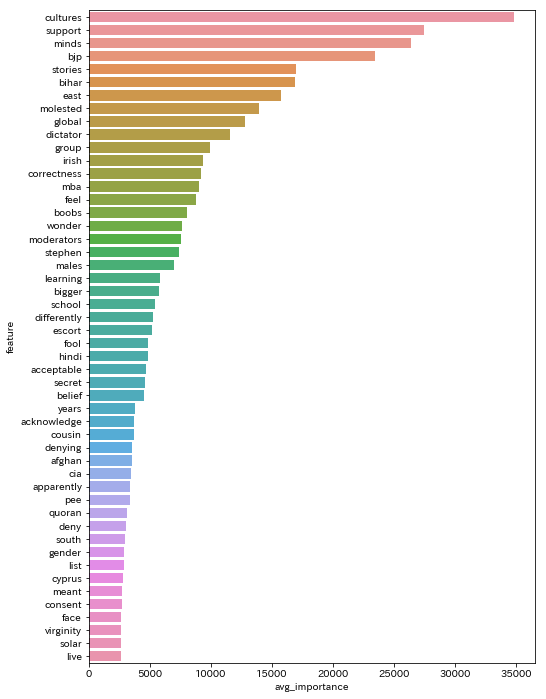

Selece Feature: 1964
[Save Feature Importance] done in 0 s
1964
['aap', 'ability', 'able', 'abortion', 'abortions', 'abuse', 'abusing', 'accept', 'acceptable', 'according', 'account', 'achieve', 'acknowledge', 'act', 'acting', 'actions', 'active', 'activists', 'actually', 'adam', 'address', 'administration', 'admission', 'admit', 'adolf', 'ads', 'adult', 'advantages', 'advice', 'affairs', 'affect', 'affected', 'afghan', 'afraid', 'africa', 'african', 'africans', 'age', 'agenda', 'agents', 'aggressive', 'ago', 'agree', 'aids', 'air', 'aircraft', 'aka', 'al', 'albanians', 'alex', 'alien', 'aliens', 'alive', 'allah', 'allow', 'allowed', 'allowing', 'alt', 'amazon', 'amendment', 'america', 'american', 'americans', 'analysis', 'ancestors', 'ancient', 'android', 'angry', 'animal', 'animals', 'anime', 'annex', 'annoy', 'annoying', 'answer', 'answering', 'answers', 'anti', 'antifa', 'anxiety', 'anybody', 'anymore', 'apartheid', 'apologize', 'app', 'apparently', 'application', 'apply', 'approac

In [13]:
with timer("Selected Train"):
    select_features, prediction = lgbm_train(select_mx, select_features)
    print(len(select_features))
    print(select_features)

In [14]:
print(f'All Done!! {time.time() - train_st_time:.0f} s')

NameError: name 'train_st_time' is not defined